In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#show all columns and rows
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [2]:
from datetime import datetime, timedelta

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import requests
import json
#from pandas.io.json import json_normalize

In [5]:
import joblib

In [6]:
key = '68bd382ddb99350655bff0bbf00171ec' #get your own from https://darksky.net/dev

# model import - choose your option

In [7]:
# Niepodległości
model_xgb = joblib.load("model/nie/model_xgb.pkl")
model_lgb = joblib.load("model/nie/model_lgb.pkl")

In [31]:
# Wokalna
model_xgb = joblib.load("model/wok/model_xgb.pkl")
model_lgb = joblib.load("model/wok/model_lgb.pkl")

# data for forcast and chart

### recent data for PM2.5

In [8]:
# Niepodległości
gios_now = json.loads(requests.get('http://api.gios.gov.pl/pjp-api/rest/data/getData/3585').text)

In [32]:
# Wokalna
gios_now = json.loads(requests.get('http://api.gios.gov.pl/pjp-api/rest/data/getData/3731').text)

In [9]:
gios_now = pd.DataFrame(gios_now['values']) 
gios_now['value'] = gios_now['value'].interpolate(limit_direction='both')
gios_now['date'] = gios_now['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
gios_now.head()

,date,value
0,2020-02-18 17:00:00,9.63
1,2020-02-18 16:00:00,14.56
2,2020-02-18 15:00:00,15.53
3,2020-02-18 14:00:00,13.27
4,2020-02-18 13:00:00,12.22


In [10]:
#date to start a chart
times = int(datetime.timestamp(min(gios_now['date'])))
times

1581811200

### data from darksky

In [11]:
dark_hour = []

In [12]:
for i in range(5):
    darksky = json.loads(requests.get('https://api.darksky.net/forecast/{}/52.2193,21.0047,{}'.format(key, times)).text)
    dark_hour.extend(darksky['hourly']['data'])
    times += 24*60*60

In [13]:
table_hour = pd.DataFrame(dark_hour) 
table_hour.head()

,apparentTemperature,cloudCover,dewPoint,humidity,icon,ozone,precipIntensity,precipProbability,precipType,pressure,summary,temperature,time,uvIndex,visibility,windBearing,windGust,windSpeed
0,24.72,0.26,29.45,0.86,clear-night,335.4,0.0,0.0,NaN,1024.0,Clear,33.32,1581807600,0,10.0,180,28.32,11.36
1,25.86,0.21,29.05,0.82,clear-night,329.1,0.0,0.0,NaN,1023.7,Clear,34.06,1581811200,0,10.0,183,28.83,10.87
2,26.57,0.22,30.22,0.85,clear-night,327.3,0.0,0.0,NaN,1023.2,Clear,34.39,1581814800,0,10.0,182,29.50,10.23
3,26.76,0.27,29.93,0.82,clear-night,326.5,0.0,0.0,NaN,1022.5,Clear,34.80,1581818400,0,10.0,187,30.92,10.94
4,27.52,0.35,30.25,0.81,partly-cloudy-night,326.1,0.0,0.0,NaN,1021.9,Partly Cloudy,35.66,1581822000,0,10.0,191,32.17,11.67


### checking if there are any missing variables

In [14]:
table_hour.columns

Index(['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 'icon',
       'ozone', 'precipIntensity', 'precipProbability', 'precipType',
       'pressure', 'summary', 'temperature', 'time', 'uvIndex', 'visibility',
       'windBearing', 'windGust', 'windSpeed'],
      dtype='object')

In [20]:
available_var = list(set(table_hour.columns) - set(['icon','ozone', 'summary', 'time', 'precipType']))
missing_var = list(set(['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 
         'precipAccumulation', 'precipIntensity', 'precipProbability',
         'pressure', 'temperature',  'uvIndex',
         'visibility', 'windBearing', 'windGust', 'windSpeed']) - set(available_var))

In [23]:
if (len(missing_var)>0):
    for var in missing_var:
        table_hour[var] = 0

### adding time variables

In [24]:
table_hour['date'] = table_hour['time'].apply(lambda x: datetime.fromtimestamp(x))
table_hour['year'] = table_hour['date'].apply(lambda x: x.year)
table_hour['month'] = table_hour['date'].apply(lambda x: x.month)
table_hour['day'] = table_hour['date'].apply(lambda x: x.day)
table_hour['hour'] = table_hour['date'].apply(lambda x: x.hour)
table_hour['day_of_week'] = table_hour['date'].apply(lambda x: x.isocalendar()[2])
table_hour['no_of_week'] = table_hour['date'].apply(lambda x: x.isocalendar()[1])

In [25]:
table_hour.columns

Index(['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 'icon',
       'ozone', 'precipIntensity', 'precipProbability', 'precipType',
       'pressure', 'summary', 'temperature', 'time', 'uvIndex', 'visibility',
       'windBearing', 'windGust', 'windSpeed', 'precipAccumulation', 'date',
       'year', 'month', 'day', 'hour', 'day_of_week', 'no_of_week'],
      dtype='object')

In [26]:
table_hour.head()

,apparentTemperature,cloudCover,dewPoint,humidity,icon,ozone,precipIntensity,precipProbability,precipType,pressure,summary,temperature,time,uvIndex,visibility,windBearing,windGust,windSpeed,precipAccumulation,date,year,month,day,hour,day_of_week,no_of_week
0,24.72,0.26,29.45,0.86,clear-night,335.4,0.0,0.0,NaN,1024.0,Clear,33.32,1581807600,0,10.0,180,28.32,11.36,0,2020-02-16 00:00:00,2020,2,16,0,7,7
1,25.86,0.21,29.05,0.82,clear-night,329.1,0.0,0.0,NaN,1023.7,Clear,34.06,1581811200,0,10.0,183,28.83,10.87,0,2020-02-16 01:00:00,2020,2,16,1,7,7
2,26.57,0.22,30.22,0.85,clear-night,327.3,0.0,0.0,NaN,1023.2,Clear,34.39,1581814800,0,10.0,182,29.50,10.23,0,2020-02-16 02:00:00,2020,2,16,2,7,7
3,26.76,0.27,29.93,0.82,clear-night,326.5,0.0,0.0,NaN,1022.5,Clear,34.80,1581818400,0,10.0,187,30.92,10.94,0,2020-02-16 03:00:00,2020,2,16,3,7,7
4,27.52,0.35,30.25,0.81,partly-cloudy-night,326.1,0.0,0.0,NaN,1021.9,Partly Cloudy,35.66,1581822000,0,10.0,191,32.17,11.67,0,2020-02-16 04:00:00,2020,2,16,4,7,7


### handling missing data

In [27]:
# interpolate

cols=[ 'apparentTemperature', 'cloudCover', 'dewPoint',
       'humidity',  'precipType', 'pressure', 'temperature',
       'time', 'uvIndex', 'visibility', 'windBearing',
       'windSpeed']

for col in cols:
    table_hour[col] = table_hour[col].interpolate(limit_direction='both')

In [28]:
# fill with 0

cols=['precipAccumulation','precipIntensity','precipProbability']

for col in cols:
    table_hour[col] = table_hour[col].fillna(0)

In [29]:
# value from another column

table_hour['windGust'] = table_hour['windGust'].fillna(table_hour['windSpeed'])

In [30]:
# information about winter break

table_hour['winter_break'] = 0 
mask = (table_hour['date'] >='2020-02-10') & (table_hour['date'] <='2020-02-23')
table_hour['winter_break'][mask] = 1

### prediction

In [31]:
feats = ['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 
         'precipAccumulation', 'precipIntensity', 'precipProbability',
         'pressure', 'temperature',  'uvIndex',
         'visibility', 'windBearing', 'windGust', 'windSpeed',
         'year', 'month', 'day',  'hour', 'day_of_week', 'no_of_week', 'winter_break']

In [32]:
prediction_xgb = np.exp(model_xgb.predict(table_hour[feats].values))
prediction_xgb

array([43.913292, 45.098904, 52.056934, 43.175888, 43.80663 , 39.498734,
       40.724922, 37.01548 , 32.429424, 35.807297, 27.72272 , 27.790869,
       27.009434, 27.3479  , 31.501934, 29.340399, 28.358366, 25.245892,
       23.345104, 20.851452, 22.603994, 25.501642, 24.874445, 22.137661,
       18.75534 , 17.233673, 18.36333 , 19.006319, 18.930443, 23.07757 ,
       23.843693, 28.670948, 26.583065, 25.57244 , 22.22495 , 19.883724,
       17.330194, 20.320143, 23.266512, 29.301594, 41.64321 , 40.38374 ,
       40.89001 , 40.228607, 40.605804, 44.816113, 44.838394, 42.586918,
       34.984154, 33.965405, 39.5834  , 30.38518 , 30.28922 , 33.080627,
       33.150944, 22.408318, 17.314493, 17.110655, 19.490067, 18.203054,
       18.214703, 17.197115, 18.25067 , 18.513165, 14.594639, 20.11207 ,
       18.012936, 20.089125, 17.794647, 29.133303, 19.766932, 21.07856 ,
       19.919022, 24.681389, 19.793488, 21.653553, 20.84047 , 21.589035,
       25.187689, 32.012417, 32.273872, 31.683378, 

In [33]:
prediction_lgb = np.exp(model_lgb.predict(table_hour[feats].values))
prediction_lgb

array([34.14398436, 35.37918873, 39.35631787, 32.86554797, 29.62246666,
       29.01130322, 28.28014308, 25.61788095, 23.30414069, 25.07046548,
       26.51666347, 26.39434865, 26.77122967, 26.07706855, 27.05872477,
       26.04728925, 25.92028972, 25.4576509 , 25.65257411, 25.95682397,
       27.09947743, 27.87758991, 27.66575974, 27.92232092, 21.37075304,
       20.48711374, 19.58270519, 19.48224709, 19.48224709, 19.06298473,
       19.9285117 , 26.6599604 , 27.05571622, 24.7871691 , 25.23591711,
       22.9824585 , 23.72773665, 26.48063262, 29.92622723, 33.19347041,
       36.69966166, 39.76102371, 40.7120307 , 41.44279283, 42.06078665,
       39.55979853, 40.42344975, 43.2970276 , 29.47405553, 33.55684306,
       36.68872808, 32.54146113, 30.29911203, 29.60983101, 30.33444776,
       24.61585285, 22.26785538, 18.7378272 , 19.12196101, 19.12196101,
       18.85831457, 19.07637956, 19.3469036 , 16.64498351, 16.27134908,
       19.51528863, 19.76956978, 24.77495848, 22.65944918, 30.36

In [34]:
table_hour['pred_xgb'] = prediction_xgb
table_hour['pred_lgb'] = prediction_lgb
table_hour.head()

,apparentTemperature,cloudCover,dewPoint,humidity,icon,ozone,precipIntensity,precipProbability,precipType,pressure,summary,temperature,time,uvIndex,visibility,windBearing,windGust,windSpeed,precipAccumulation,date,year,month,day,hour,day_of_week,no_of_week,winter_break,pred_xgb,pred_lgb
0,24.72,0.26,29.45,0.86,clear-night,335.4,0.0,0.0,NaN,1024.0,Clear,33.32,1581807600,0,10.0,180,28.32,11.36,0,2020-02-16 00:00:00,2020,2,16,0,7,7,1,43.913292,34.143984
1,25.86,0.21,29.05,0.82,clear-night,329.1,0.0,0.0,NaN,1023.7,Clear,34.06,1581811200,0,10.0,183,28.83,10.87,0,2020-02-16 01:00:00,2020,2,16,1,7,7,1,45.098904,35.379189
2,26.57,0.22,30.22,0.85,clear-night,327.3,0.0,0.0,NaN,1023.2,Clear,34.39,1581814800,0,10.0,182,29.50,10.23,0,2020-02-16 02:00:00,2020,2,16,2,7,7,1,52.056934,39.356318
3,26.76,0.27,29.93,0.82,clear-night,326.5,0.0,0.0,NaN,1022.5,Clear,34.80,1581818400,0,10.0,187,30.92,10.94,0,2020-02-16 03:00:00,2020,2,16,3,7,7,1,43.175888,32.865548
4,27.52,0.35,30.25,0.81,partly-cloudy-night,326.1,0.0,0.0,NaN,1021.9,Partly Cloudy,35.66,1581822000,0,10.0,191,32.17,11.67,0,2020-02-16 04:00:00,2020,2,16,4,7,7,1,43.806629,29.622467


In [35]:
chart_data = table_hour[['date','pred_xgb','pred_lgb']]

# chart

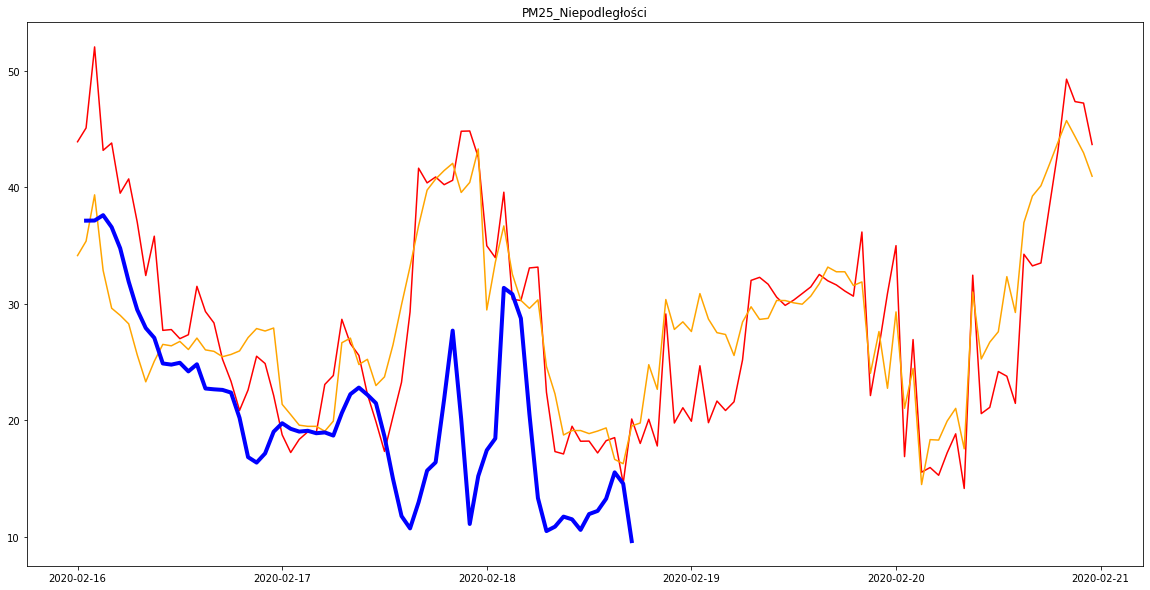

In [36]:
plt.figure(figsize=(20,10))
plt.plot(chart_data['date'], chart_data['pred_xgb'], color='red') #forcast
plt.plot(chart_data['date'], chart_data['pred_lgb'], color='orange') #forcast
plt.plot(gios_now['date'], gios_now['value'], color='blue', linewidth = 4) #actual

plt.title('PM25_Niepodległości')
plt.show()

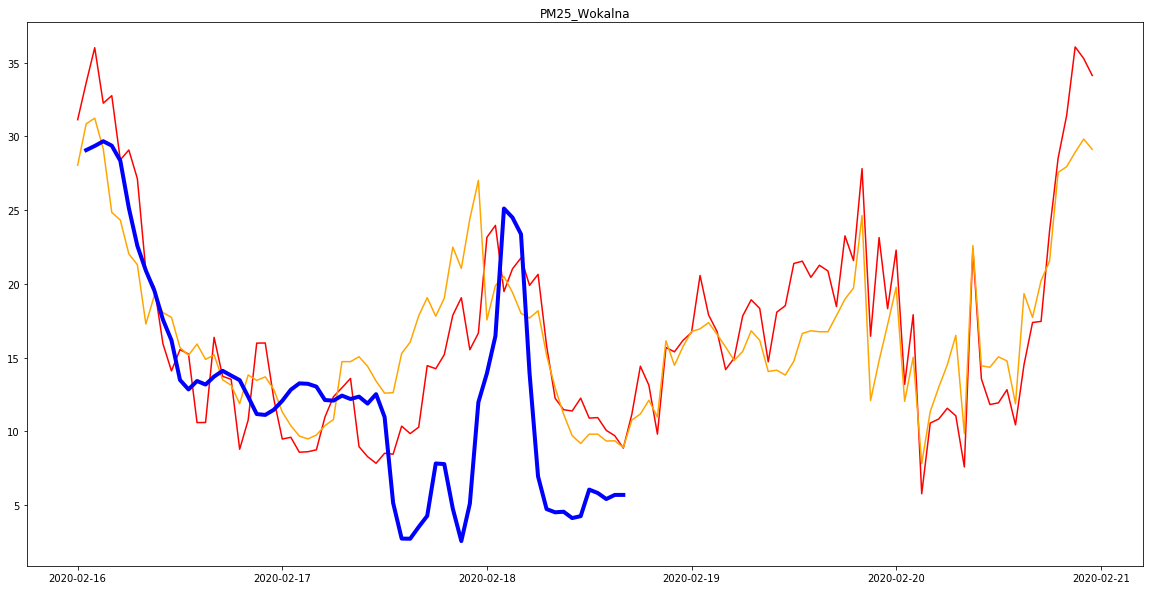

In [39]:
plt.figure(figsize=(20,10))
plt.plot(chart_data['date'], chart_data['pred_xgb'], color='red') #forcast
plt.plot(chart_data['date'], chart_data['pred_lgb'], color='orange') #forcast
plt.plot(gios_now['date'], gios_now['value'], color='blue', linewidth = 4) #actual

plt.title('PM25_Wokalna')
plt.show()